# NARX shoreline model results
This notebook is designed to plot 

In [6]:
# magic
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import sys, os, re
import glob, pickle
import numpy as np
import pandas as pd
from shoreNARX import TrainingClass
from shoreNARX.model_class import calc_performance_
from shoreNARX.plotting import (
    plot_CV_ensemble, plot_sensitivity_analysis,
    plot_CV_ensemble_compare,
    plot_errorwindow_analysis,
    plot_hysteresis, 
    plot_compare_structure_byfold, plot_compare_structure
)
from shoreNARX.analyses import (run_sensitivity_analysis, run_errorwindow_analysis, run_hysteresis_analysis)

import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
baseLoc = '.'
# set pandas print format to 3 decimal places
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Report model performance 
With optimised hyperparams and 5-fold CV.

trainObj.statsOut gives a [[{} * CV_folds] * random_states] object

First define a function that loads the model results for a given config file.

In [9]:
def load_model_results(config_file):
    # init object
    config_path = os.path.join(baseLoc,'config',config_file)
    trainObj = TrainingClass(**{'baseDir':baseLoc,'config':config_path})
    # train as per config
    trainObj.load_cv_test()

    # data collector
    dataCollector = []

    # get the performance metrics for each fold and ensemble
    for thisFold in np.arange(trainObj.statsOut[0].__len__()):
        for thisEnsemble in np.arange(trainObj.statsOut.__len__()):
            tmpRMSE, tmpNMSE, tmpR, tmpR2 = calc_performance_(
                trainObj.statsOut[thisEnsemble][thisFold]['test']['modY'],
                trainObj.statsOut[thisEnsemble][thisFold]['test']['obsY']
            )
            dataCollector.append(
                {
                    'testRMSE': tmpRMSE,
                    'testNMSE': tmpNMSE,
                    'testR': tmpR,
                    'testR2': tmpR2,
                    'fold': thisFold,
                    'ensemble': thisEnsemble
                }
            )

    # collate dataCollector into a dataframe
    performanceData = pd.DataFrame(dataCollector)
    print('Performance by fold:')
    # now calculate the by fold std
    std_byFold = performanceData.groupby(by='fold').std()
    std_byFold = std_byFold[['testRMSE','testNMSE','testR','testR2']]
    std_byFold.columns = ['(std testRMSE)','(std testNMSE)','(std testR)','(std testR3)']
    byFold = pd.concat([
        performanceData.groupby(by='fold').mean(),
        std_byFold
    ], axis=1).drop(columns=['ensemble'])
    display(byFold)
    print('Performance average across fold and ensemble:')
    std_total = performanceData.std().to_frame().T.drop(columns=['fold','ensemble'])
    std_total.columns = ['(std testRMSE)','(std testNMSE)','(std testR)','(std testR2)']
    byTotal = pd.concat([
        performanceData.mean().to_frame().T,
        std_total
    ],axis=1).drop(columns=['fold','ensemble'])
    display(byTotal)

    return trainObj, performanceData

Narrabeen performance check

In [10]:
case = 'base'

print('#'*80)
print('Narrabeen')
narra_base, narra_base_perf = load_model_results('narra_{}_config.json'.format(case))
print('#'*80)
print('Tairua')
tairua_base, tairua_base_perf = load_model_results('tairua_{}_config.json'.format(case))

# restore the base case
narra_base.restore_model(0,0)
tairua_base.restore_model(0,0)

################################################################################
Narrabeen
Performance by fold:


testRMSE  testNMSE  testR  testR2  (std testRMSE)  (std testNMSE)  \
fold                                                                      
0        5.807     0.516  0.783   0.326           0.790           0.145   
1        5.567     0.411  0.776   0.379           0.241           0.036   
2        4.072     0.232  0.889   0.123           0.351           0.041   
3        6.993     0.690  0.869   0.380           1.339           0.245   
4        6.224     0.427  0.783   0.198           0.336           0.046   

      (std testR)  (std testR3)  
fold                             
0           0.044         0.029  
1           0.026         0.017  
2           0.017         0.026  
3           0.020         0.036  
4           0.030         0.028

Performance average across fold and ensemble:


testRMSE  testNMSE  testR  testR2  (std testRMSE)  (std testNMSE)  \
0     5.733     0.455  0.820   0.281           1.206           0.198   

   (std testR)  (std testR2)  
0        0.056         0.107

################################################################################
Tairua
Performance by fold:


testRMSE  testNMSE  testR  testR2  (std testRMSE)  (std testNMSE)  \
fold                                                                      
0        4.560     0.538  0.722   0.291           0.276           0.064   
1        4.386     0.956  0.435   0.216           0.224           0.097   
2        5.115     0.634  0.658   0.306           0.162           0.040   
3        3.802     0.613  0.632   0.230           0.149           0.049   
4        5.322     1.170  0.253  -0.032           0.184           0.081   

      (std testR)  (std testR3)  
fold                             
0           0.049         0.028  
1           0.071         0.034  
2           0.046         0.025  
3           0.045         0.023  
4           0.045         0.081

Performance average across fold and ensemble:


testRMSE  testNMSE  testR  testR2  (std testRMSE)  (std testNMSE)  \
0     4.637     0.782  0.540   0.202           0.580           0.252   

   (std testR)  (std testR2)  
0        0.181         0.130

# Show model predictions on train and test
The model is only provided with the initial shoreline (i.e., at the first timestep) for the plots below in both the train and test periods.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


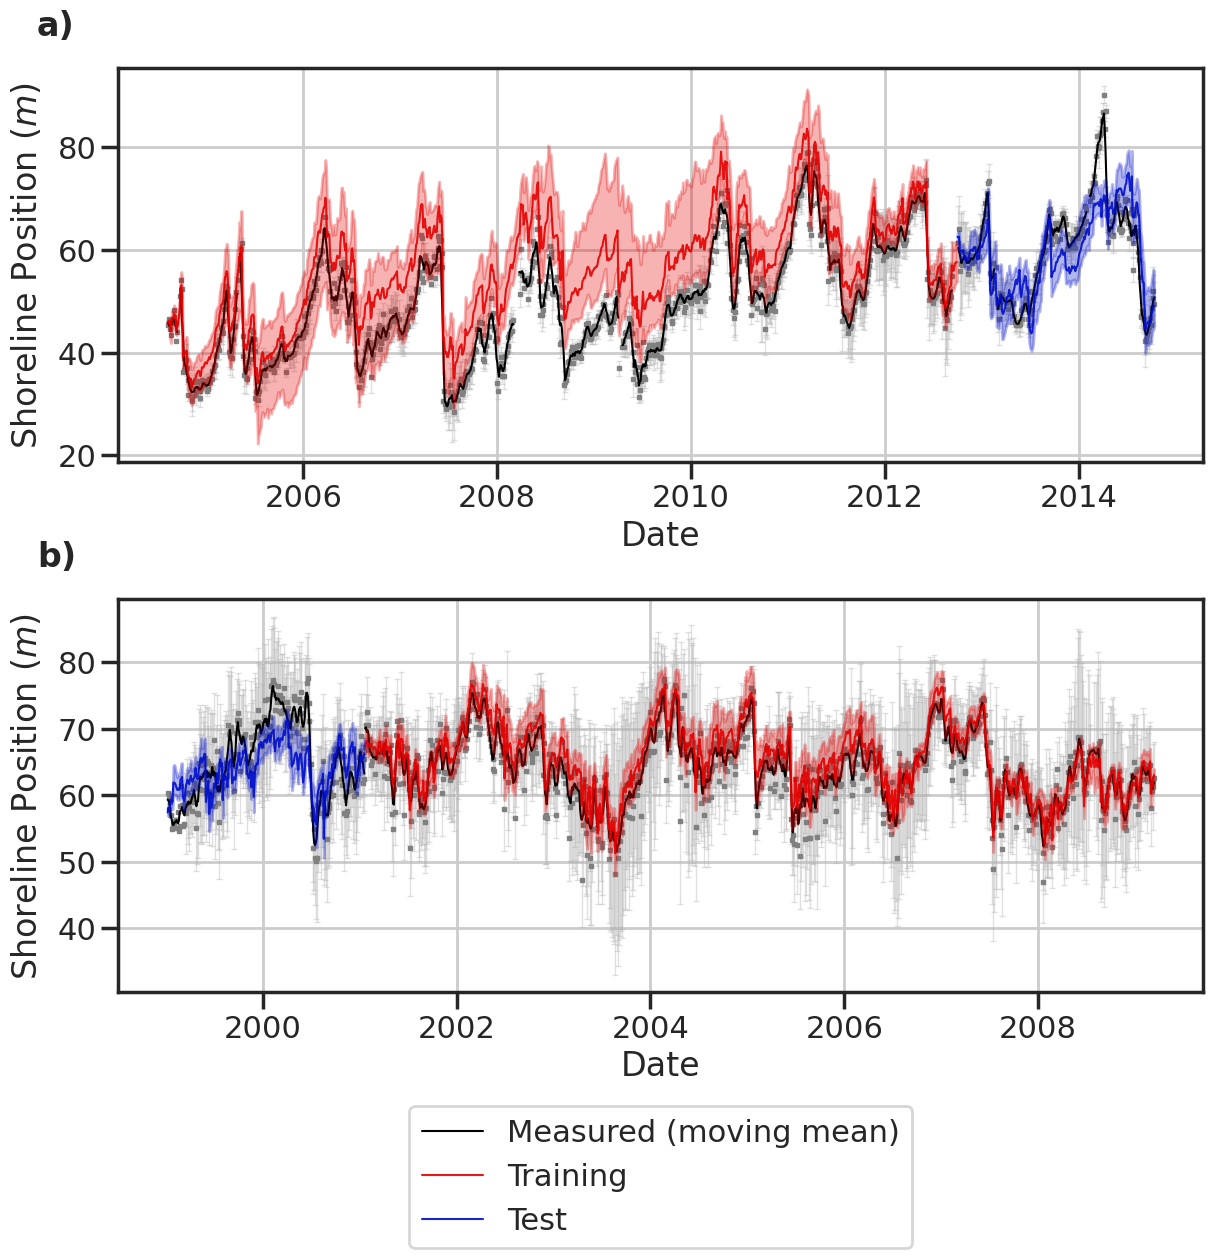

In [11]:
savebool = True
case = 'base'
fold_a = 4
fold_b = 0

sns.set_context("poster")
sns.set_style("ticks",{'axes.grid': True})
# create a figure
fig = plt.figure(figsize=(14,12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)        

# plot one from Narrabeen and one from Tairua      
plot_CV_ensemble(
    narra_base.statsOut,
    fold_a,
    ax=ax1
)
plot_CV_ensemble(
    tairua_base.statsOut,
    fold_b,
    ax=ax2
)
# formatting
ax2.get_legend()._loc = 9
# set bbox to anchor legend
ax2.get_legend().set_bbox_to_anchor((0.5, -0.25))
# add label a) in top left of ax1 and b) in top left of ax2
txt = ax1.text(-0.075, 1.15, 'a)', transform=ax1.transAxes, va='top', fontweight='bold')
ax2.text(-0.075, 1.15, 'b)', transform=ax2.transAxes, va='top', fontweight='bold')
plt.subplots_adjust(hspace=0.35)

if savebool: 
    # save for paper
    savePath =  os.path.join('.','figures','CV', 'case_{}'.format(case),
                                'CVtesting_fold_{}_{}.pdf'.format(fold_a, fold_b))
    os.makedirs(os.path.dirname(savePath), exist_ok=True)
    plt.savefig(savePath, bbox_extra_artists=(ax2.get_legend(),txt), bbox_inches='tight', dpi=600)
    plt.savefig(savePath.replace('.pdf','.png'), bbox_extra_artists=(ax2.get_legend(),txt), bbox_inches='tight', dpi=600)

plt.show()

# Assess model sensitivity to input variables
### Input variable sensitivity analysis
Here we call the function `run_sensitivity_analysis` which randomly permutes input variables one at a time to assess the drop in model performance. The function returns a dataframe with the drop in model performance for each input variable.

Narrabeen


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:33<00:00,  1.65s/it]


Tairua


100%|██████████| 20/20 [00:33<00:00,  1.69s/it]
/project/code/shoreNARX/plotting/analysis_visualisaton.py:199: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['$H_{sig}$','$T_{p}$','$W_{dir}$','$WL$','$x_{t-1}$'],rotation=45)
/project/code/shoreNARX/plotting/analysis_visualisaton.py:200: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['$H_{sig}$','$T_{p}$','$W_{dir}$','$WL$','$x_{t-1}$'],rotation=45)


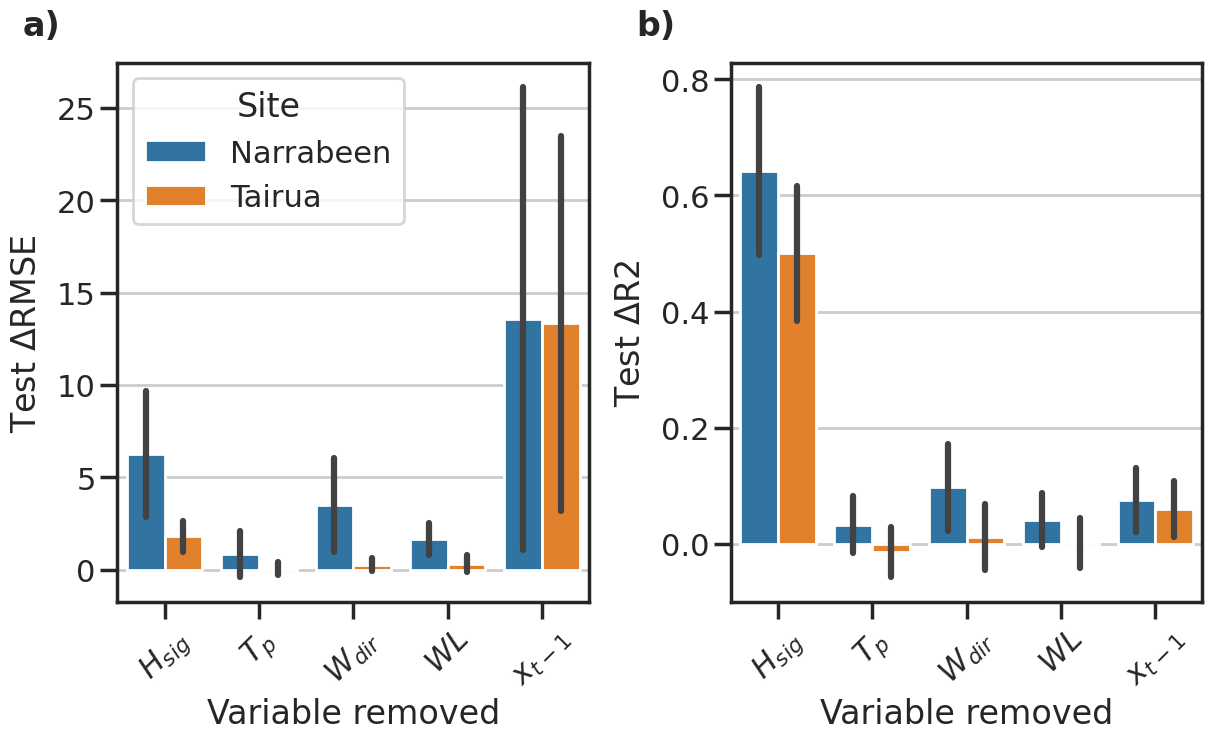

In [12]:
# Feature permutation analysis
nreps = 1 # number of shuffling repetitions for each CV fold for each run number
print('Narrabeen')
looDF_narra = run_sensitivity_analysis(narra_base, nreps=nreps, verbose=False)
print('Tairua')
looDF_tairua = run_sensitivity_analysis(tairua_base, nreps=nreps, verbose=False)

# Combine across sites
case = 'base'
looDF = pd.concat([looDF_narra,looDF_tairua],axis=0,ignore_index=True)
plot_sensitivity_analysis(looDF,savebool=True, case=case)

In [13]:
display(looDF.query('Variable == "shl_-1_0" and Site == "Tairua"')['RMSE'].mean())
display(looDF.query('Variable == "shl_-1_0" and Site == "Narrabeen"')['RMSE'].mean())

13.340847332728833

13.592452259264476

# Model structure tests
Compare the model with:

- AR1 train + test: feedback connection whereby the model prediction of the absolute shoreline position from the previous timestep ($\hat{x}_{t-1}$) is given as an input during both training and testing.
- AR1 test only: observed values of $x_{t-1}$ used as input to the model during training. During testing the model input is switched to the model prediction of the absolute shoreline position from the previous timestep ($\hat{x}_{t-1}$) to allow forward prediction.
- No $x_{t-1}$: model trained without the input $x_{t-1}$.

In [14]:
case = 'nohist'

print('#'*80)
print('Narrabeen')
narra_nohist, narra_nohist_perf = load_model_results('narra_{}_config.json'.format(case))
print('#'*80)
print('Tairua')
tairua_nohist, tairua_nohist_perf = load_model_results('tairua_{}_config.json'.format(case))

# restore a model
narra_nohist.restore_model(0,0)
tairua_nohist.restore_model(0,0)

################################################################################
Narrabeen
Performance by fold:


testRMSE  testNMSE  testR  testR2  (std testRMSE)  (std testNMSE)  \
fold                                                                      
0        7.691     0.896  0.563   0.320           0.663           0.152   
1        8.848     1.041  0.459   0.285           0.691           0.160   
2        6.152     0.529  0.805   0.110           0.521           0.089   
3        4.830     0.326  0.852   0.331           0.804           0.130   
4       11.225     1.399  0.427   0.113           1.113           0.266   

      (std testR)  (std testR3)  
fold                             
0           0.105         0.030  
1           0.091         0.047  
2           0.044         0.015  
3           0.018         0.018  
4           0.077         0.020

Performance average across fold and ensemble:


testRMSE  testNMSE  testR  testR2  (std testRMSE)  (std testNMSE)  \
0     7.749     0.838  0.621   0.232           2.348           0.415   

   (std testR)  (std testR2)  
0        0.191         0.104

################################################################################
Tairua
Performance by fold:


testRMSE  testNMSE  testR  testR2  (std testRMSE)  (std testNMSE)  \
fold                                                                      
0        7.722     1.572  0.432   0.300           1.205           0.505   
1        4.675     1.091  0.467   0.222           0.397           0.188   
2        5.013     0.613  0.697   0.289           0.449           0.111   
3        4.516     0.872  0.642   0.254           0.452           0.188   
4        7.613     2.536 -0.006   0.124           1.924           1.363   

      (std testR)  (std testR3)  
fold                             
0           0.122         0.020  
1           0.074         0.015  
2           0.071         0.018  
3           0.029         0.031  
4           0.153         0.029

Performance average across fold and ensemble:


testRMSE  testNMSE  testR  testR2  (std testRMSE)  (std testNMSE)  \
0     5.908     1.337  0.446   0.238           1.791           0.941   

   (std testR)  (std testR2)  
0        0.267         0.067

In [15]:
case = 'ar1test'

print('#'*80)
print('Narrabeen')
narra_ar1test, narra_ar1test_perf = load_model_results('narra_{}_config.json'.format(case))
print('#'*80)
print('Tairua')
tairua_ar1test, tairua_ar1test_perf = load_model_results('tairua_{}_config.json'.format(case))

# restore a model
narra_ar1test.restore_model(0,0)
tairua_ar1test.restore_model(0,0)

################################################################################
Narrabeen
Performance by fold:


testRMSE  testNMSE  testR  testR2  (std testRMSE)  (std testNMSE)  \
fold                                                                      
0        6.044     0.555  0.725   0.310           0.632           0.114   
1        6.775     0.610  0.662   0.340           0.473           0.084   
2        4.064     0.230  0.893   0.114           0.239           0.028   
3        6.236     0.555  0.863   0.369           1.396           0.241   
4        6.710     0.497  0.759   0.207           0.462           0.069   

      (std testR)  (std testR3)  
fold                             
0           0.063         0.025  
1           0.050         0.022  
2           0.007         0.023  
3           0.023         0.029  
4           0.028         0.037

Performance average across fold and ensemble:


testRMSE  testNMSE  testR  testR2  (std testRMSE)  (std testNMSE)  \
0     5.966     0.489  0.781   0.268           1.240           0.185   

   (std testR)  (std testR2)  
0        0.095         0.099

################################################################################
Tairua
Performance by fold:


testRMSE  testNMSE  testR  testR2  (std testRMSE)  (std testNMSE)  \
fold                                                                      
0        4.380     0.499  0.741   0.300           0.442           0.100   
1        4.283     0.914  0.448   0.228           0.300           0.129   
2        4.787     0.559  0.711   0.294           0.395           0.091   
3        3.590     0.547  0.693   0.253           0.143           0.044   
4        5.282     1.156  0.248   0.125           0.366           0.158   

      (std testR)  (std testR3)  
fold                             
0           0.059         0.030  
1           0.071         0.018  
2           0.081         0.030  
3           0.024         0.025  
4           0.083         0.027

Performance average across fold and ensemble:


testRMSE  testNMSE  testR  testR2  (std testRMSE)  (std testNMSE)  \
0     4.464     0.735  0.568   0.240           0.658           0.281   

   (std testR)  (std testR2)  
0        0.203         0.069

In [16]:
# check hist vs no hist
print('Test X shape base:{}'.format(narra_base.model.testX.shape))
print('Test X shape nohist:{}'.format(narra_nohist.model.testX.shape))
print('Test X shape ar1test:{}'.format(narra_ar1test.model.testX.shape))

Test X shape base:(248, 193)
Test X shape nohist:(248, 192)
Test X shape ar1test:(248, 193)


In [17]:
hist_nohist_comp = pd.concat([
    narra_base_perf.assign(site='narra').assign(case='AR1 train + test'),
    narra_nohist_perf.assign(site='narra').assign(case='No $x_{t-1}$'),
    tairua_base_perf.assign(site='tairua').assign(case='AR1 train + test'),
    tairua_nohist_perf.assign(site='tairua').assign(case='No $x_{t-1}$'),
    narra_ar1test_perf.assign(site='narra').assign(case='AR1 test only'),
    tairua_ar1test_perf.assign(site='tairua').assign(case='AR1 test only')
])
hist_nohist_comp['fold'] += 1

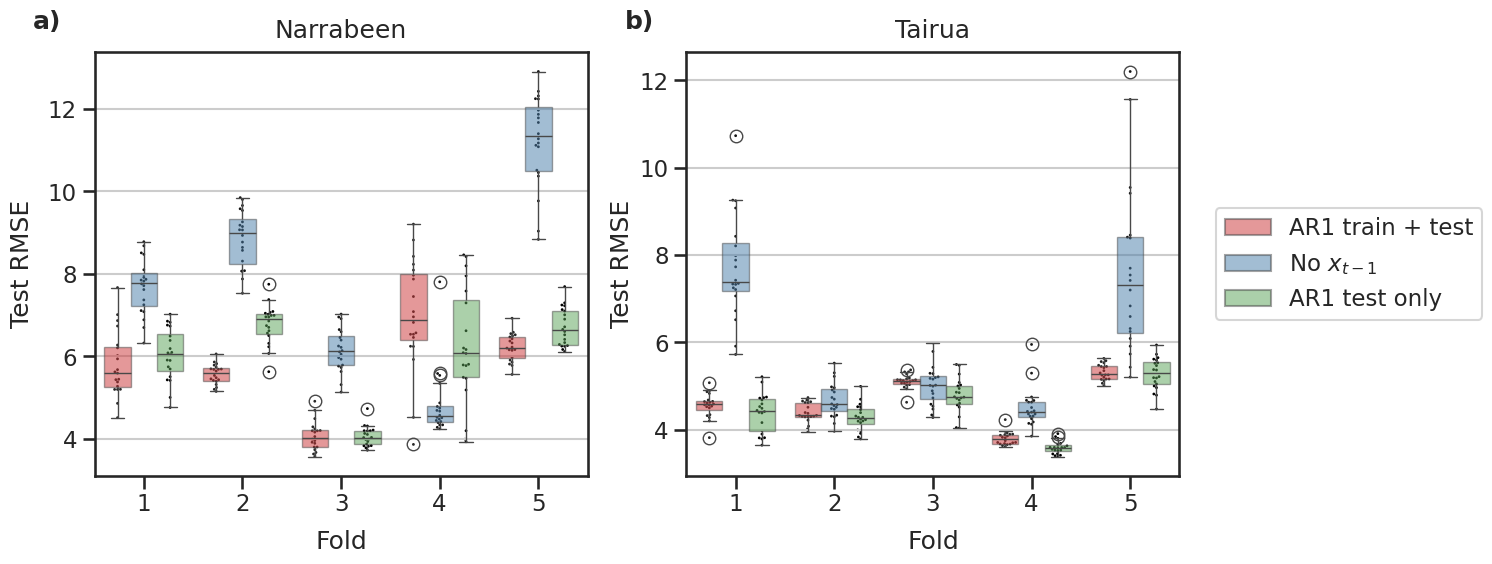

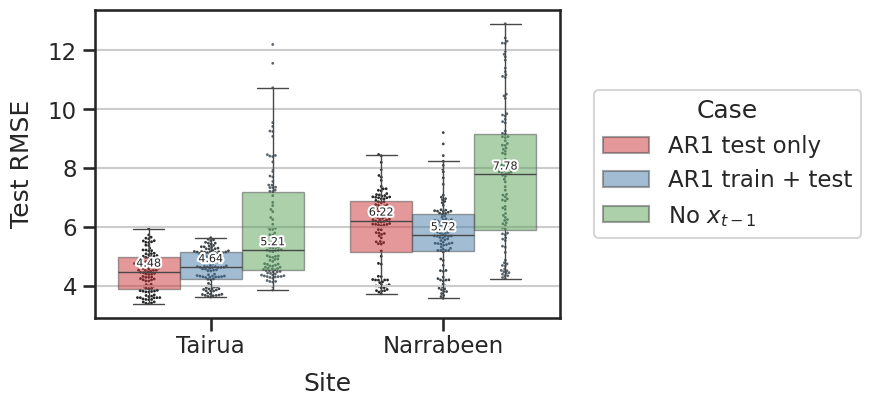

In [18]:
savebool = True
plot_compare_structure_byfold(hist_nohist_comp,savebool=savebool)
plot_compare_structure(hist_nohist_comp,savebool=savebool)

### Check the error window for each structure

In [19]:
# Forward forecast with and without recurrent feature
trainedObjects = {
    'base_narra': narra_base,
    'base_tairua': tairua_base,
    'nohist_narra': narra_nohist,
    'nohist_tairua': tairua_nohist,
    'ar1test_narra': narra_ar1test,
    'ar1test_tairua': tairua_ar1test
}
errWindowData = run_errorwindow_analysis(trainedObjects)
# rename the cases 
errWindowData['case'] = errWindowData['case'].replace({
    'base_CV': 'AR1 train + test',
    'nohist_CV': 'No $x_{t-1}$',
    'ar1test_CV': 'AR1 test only'
})

Running base_narra:
Done!
Running base_tairua:
Done!
Running nohist_narra:
Done!
Running nohist_tairua:
Done!
Running ar1test_narra:
Done!
Running ar1test_tairua:
Done!


In [20]:
errWindowData

site   hist  cvFold  units              case variable  value
0        narra   True   0.000      0  AR1 train + test        3  1.133
1        narra   True   1.000      1  AR1 train + test        3  0.442
2        narra   True   2.000      2  AR1 train + test        3  0.232
3        narra   True   3.000      3  AR1 train + test        3 -1.681
4        narra   True   4.000      4  AR1 train + test        3    NaN
...        ...    ...     ...    ...               ...      ...    ...
148795  tairua  False   0.000     95     AR1 test only      744  2.857
148796  tairua  False   1.000     96     AR1 test only      744 -2.084
148797  tairua  False   2.000     97     AR1 test only      744  3.772
148798  tairua  False   3.000     98     AR1 test only      744  0.461
148799  tairua  False   4.000     99     AR1 test only      744  1.132

[148800 rows x 7 columns]

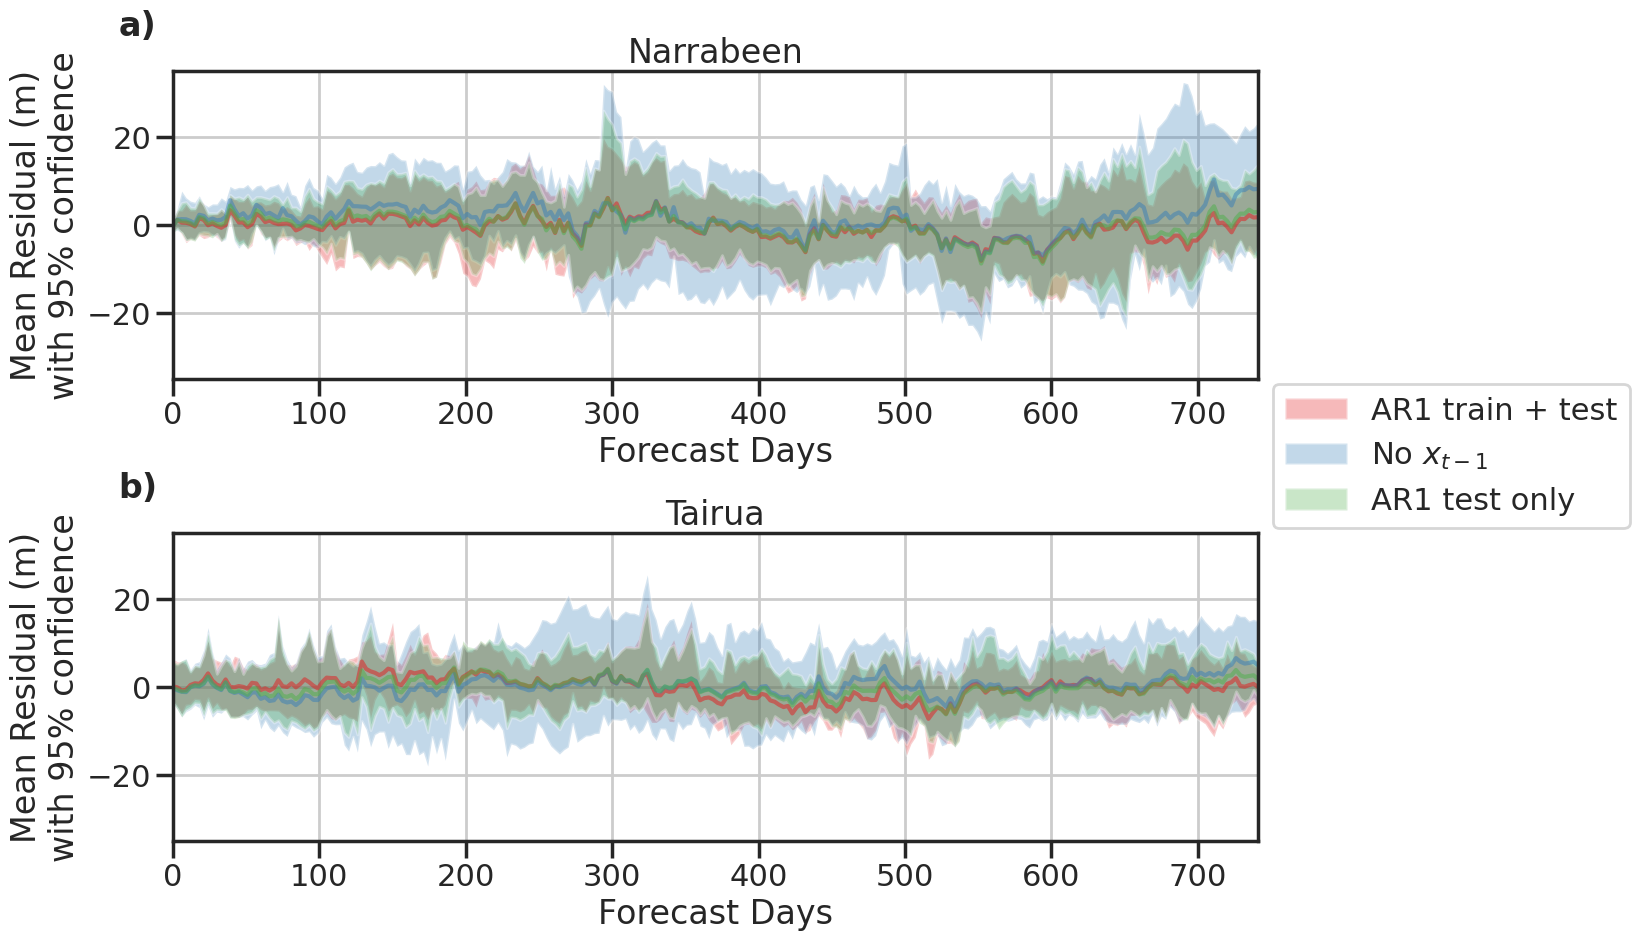

In [15]:
plot_errorwindow_analysis(errWindowData, savebool=True)

# Other superceded tests

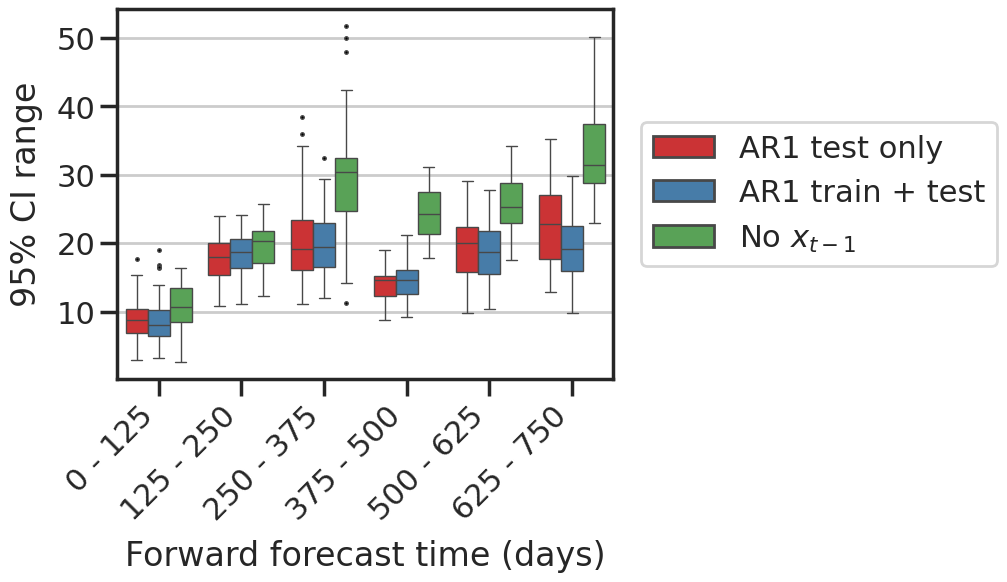

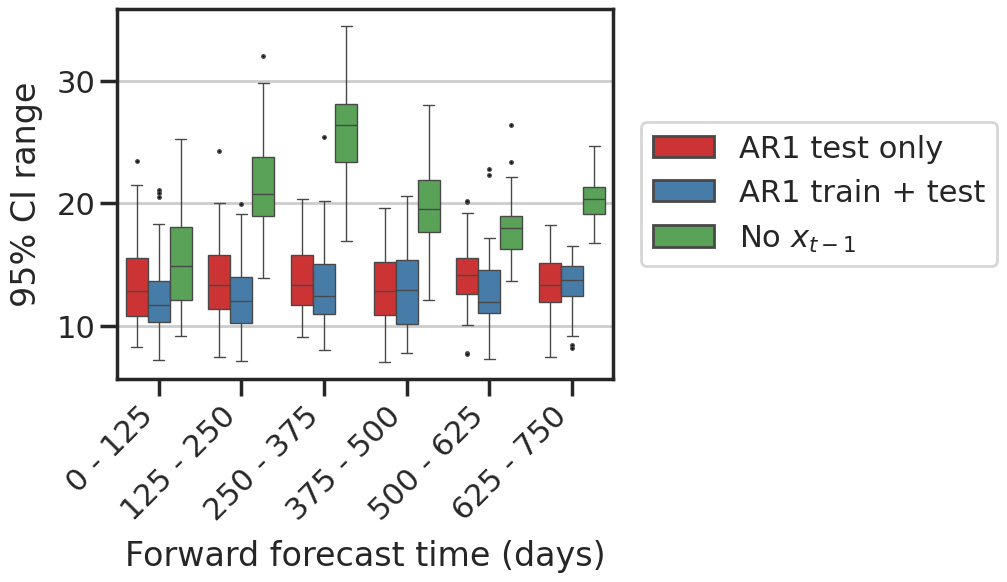

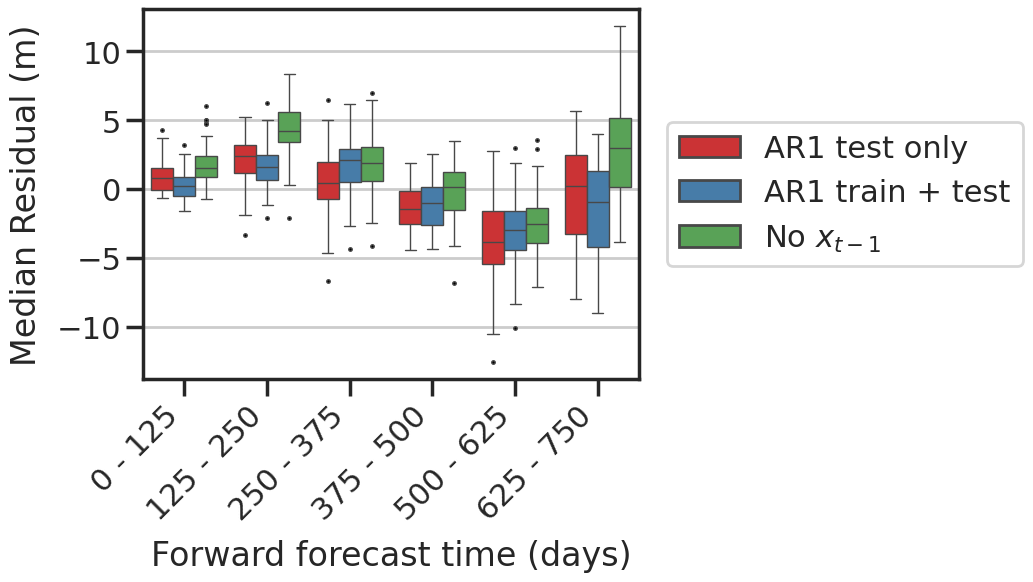

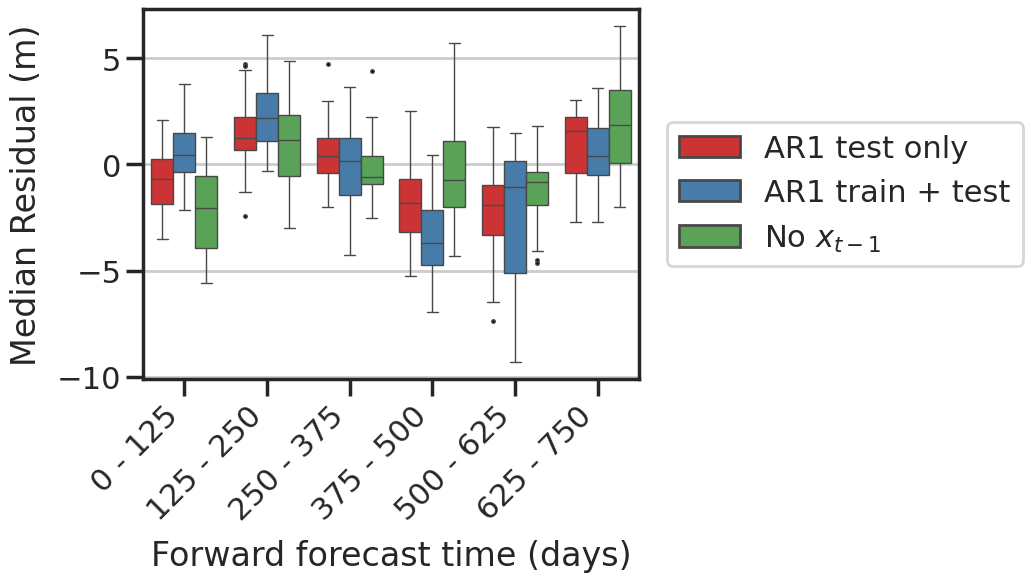

In [16]:
# group by case, site and get the size of the 95 percent confidence interval at each value of variable, we then want to categorise into bins of 50 for boxplots of the 95% values
groupedErrWindowData = errWindowData.drop(columns=['hist','cvFold','units']).groupby(by=['case','site','variable'],as_index=False).quantile(0.025).rename({'value':'lower'},axis=1)

groupedErrWindowData['upper'] = errWindowData.drop(columns=['hist','cvFold','units']).groupby(by=['case','site','variable'],as_index=False).quantile(0.975)['value']

groupedErrWindowData['median'] = errWindowData.drop(columns=['hist','cvFold','units']).groupby(by=['case','site','variable'],as_index=False).median()['value']

groupedErrWindowData['range'] = groupedErrWindowData['upper'] - groupedErrWindowData['lower']
bin_width = 125
groupedErrWindowData['bin'] = pd.cut(groupedErrWindowData['variable'], bins=np.arange(0,groupedErrWindowData['variable'].max()+bin_width,bin_width))
# groupedErrWindowData['bin_label'] = groupedErrWindowData['bin'].apply(lambda x: x.mid)
groupedErrWindowData['bin_label'] = groupedErrWindowData['bin'].apply(lambda x: '{} - {}'.format(x.left,x.right))

groupedErrWindowData
sns.boxplot(
    data=groupedErrWindowData.query('site=="narra"'),
    x='bin_label',y='range',hue='case',palette='Set1',
    flierprops=dict(marker='.', markersize=5, markerfacecolor='k')
)
plt.legend(loc=6, bbox_to_anchor=(1.025,0.5))
# rotate the x labels
plt.xticks(rotation=45, ha='right')
plt.ylabel('95% CI range', labelpad=10)
plt.xlabel('Forward forecast time (days)', labelpad=10)
plt.show()
sns.boxplot(
    data=groupedErrWindowData.query('site=="tairua"'),
    x='bin_label',y='range',hue='case',palette='Set1',
    flierprops=dict(marker='.', markersize=5, markerfacecolor='k')
)
plt.legend(loc=6, bbox_to_anchor=(1.025,0.5))
plt.xticks(rotation=45, ha='right')
plt.ylabel('95% CI range', labelpad=10)
plt.xlabel('Forward forecast time (days)', labelpad=10)
plt.show()

sns.boxplot(
    data=groupedErrWindowData.query('site=="narra"'),
    x='bin_label',y='median',hue='case',palette='Set1',
    flierprops=dict(marker='.', markersize=5, markerfacecolor='k')
)
plt.legend(loc=6, bbox_to_anchor=(1.025,0.5))
# rotate the x labels
plt.xticks(rotation=45, ha='right')
plt.ylabel('Median Residual (m)', labelpad=10)
plt.xlabel('Forward forecast time (days)', labelpad=10)
plt.show()
sns.boxplot(
    data=groupedErrWindowData.query('site=="tairua"'),
    x='bin_label',y='median',hue='case',palette='Set1',
    flierprops=dict(marker='.', markersize=5, markerfacecolor='k')
)
plt.legend(loc=6, bbox_to_anchor=(1.025,0.5))
plt.xticks(rotation=45, ha='right')
plt.ylabel('Median Residual (m)', labelpad=10)
plt.xlabel('Forward forecast time (days)', labelpad=10)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


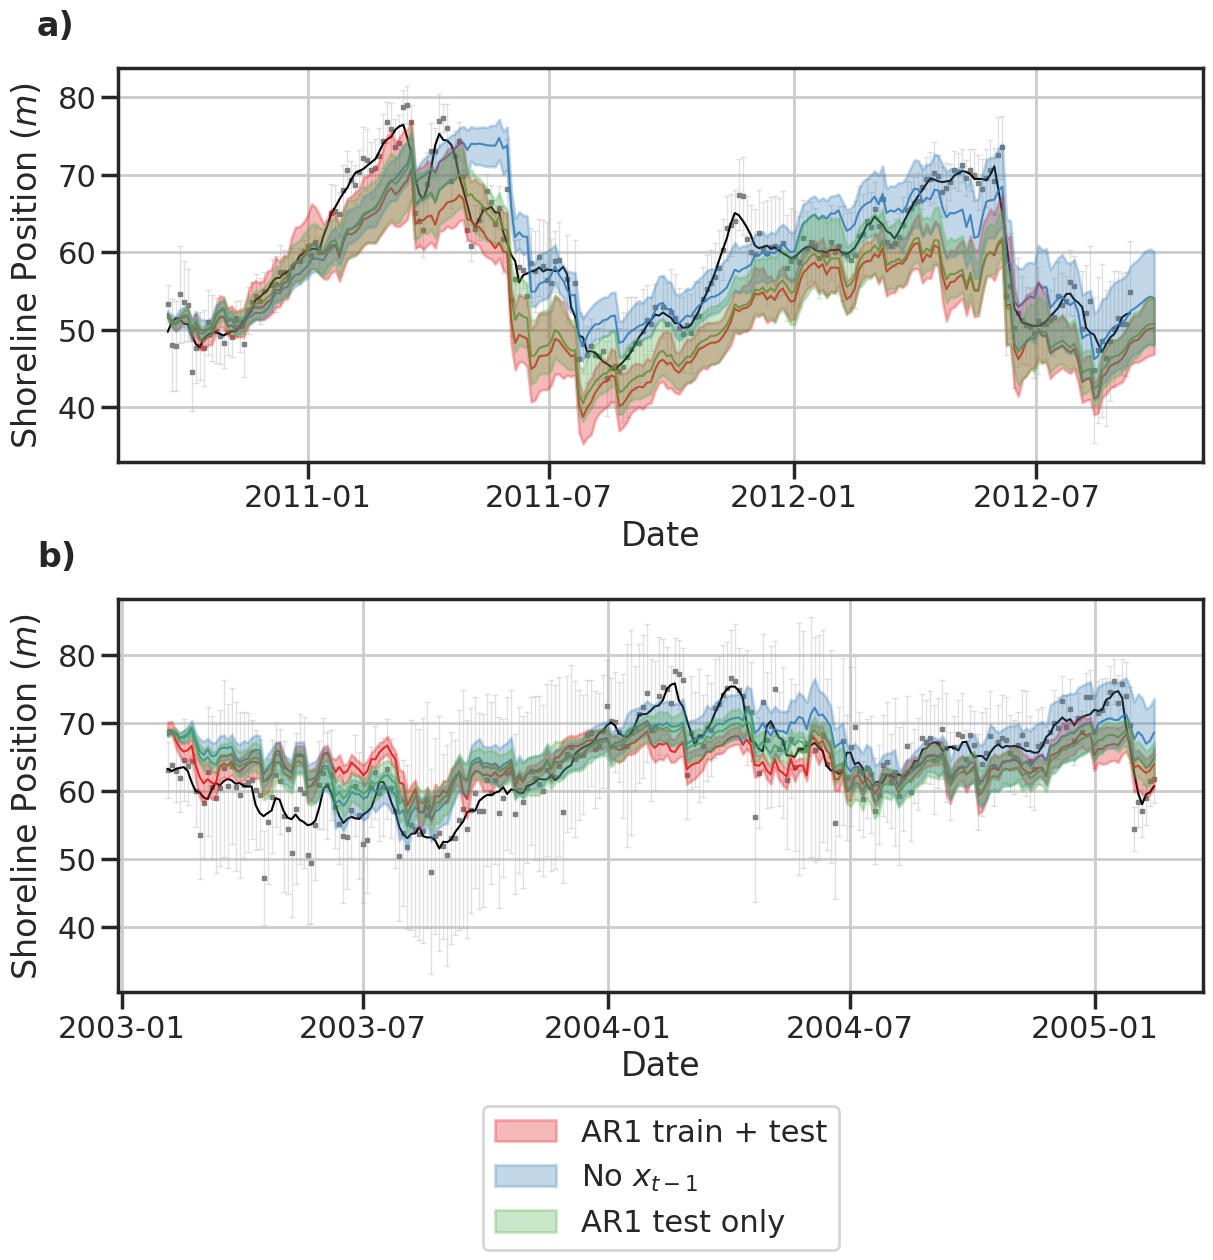

In [17]:
savebool = True
case = 'structure_comp'
fold_a = 3
fold_b = 2

sns.set_context("poster")
sns.set_style("ticks",{'axes.grid': True})
# create a figure
fig = plt.figure(figsize=(14,12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)        

# plot one from Narrabeen and one from Tairua      
plot_CV_ensemble_compare(
    {'AR1 train + test':narra_base.statsOut,'No $x_{t-1}$':narra_nohist.statsOut,'AR1 test only': narra_ar1test.statsOut},
    fold_a,
    ax=ax1
)
plot_CV_ensemble_compare(
    {'AR1 train + test':tairua_base.statsOut,'No $x_{t-1}$':tairua_nohist.statsOut,'AR1 test only': tairua_ar1test.statsOut},
    fold_b,
    ax=ax2
)

# formatting
ax2.get_legend()._loc = 9
# set bbox to anchor legend
ax2.get_legend().set_bbox_to_anchor((0.5, -0.25))
# add label a) in top left of ax1 and b) in top left of ax2
txt = ax1.text(-0.075, 1.15, 'a)', transform=ax1.transAxes, va='top', fontweight='bold')
ax2.text(-0.075, 1.15, 'b)', transform=ax2.transAxes, va='top', fontweight='bold')
plt.subplots_adjust(hspace=0.35)

if savebool: 
    # save for paper
    savePath =  os.path.join('.','figures','CV', 'case_{}'.format(case),
                                'CVtesting_fold_{}_{}.pdf'.format(fold_a, fold_b))
    os.makedirs(os.path.dirname(savePath), exist_ok=True)
    plt.savefig(savePath, bbox_extra_artists=(ax2.get_legend(),txt), bbox_inches='tight', dpi=600)
    plt.savefig(savePath.replace('.pdf','.png'), bbox_extra_artists=(ax2.get_legend(),txt), bbox_inches='tight', dpi=600)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


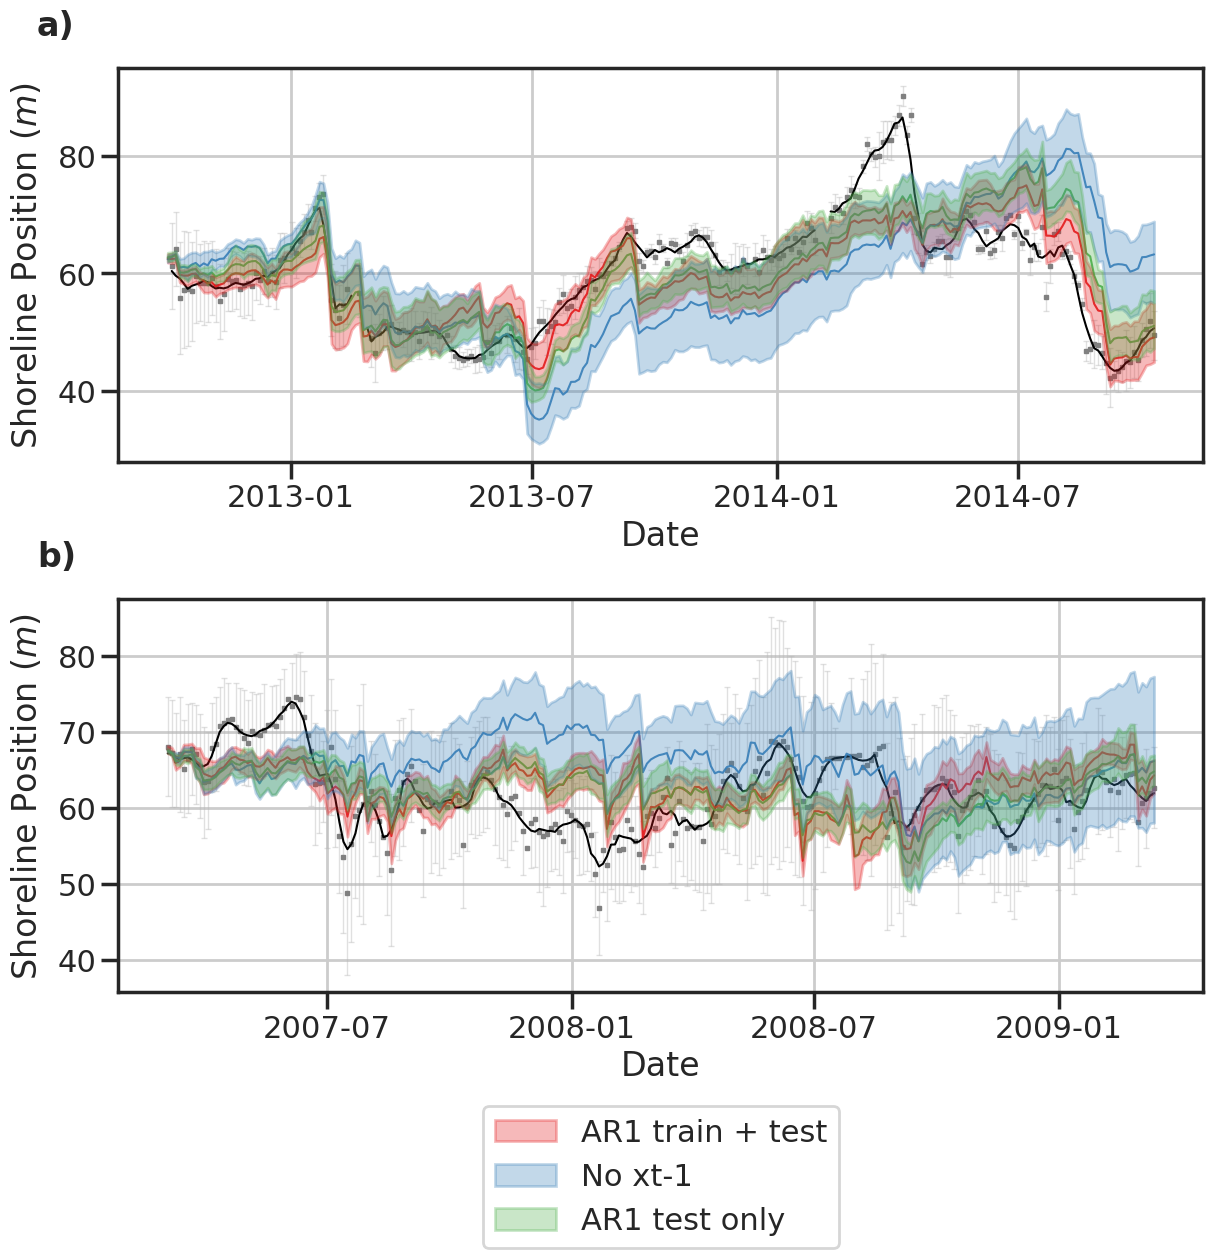

In [18]:
savebool = True
fold_a = 4
fold_b = 4

sns.set_context("poster")
sns.set_style("ticks",{'axes.grid': True})
# create a figure
fig = plt.figure(figsize=(14,12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)        

# plot one from Narrabeen and one from Tairua      
plot_CV_ensemble_compare(
    {'AR1 train + test':narra_base.statsOut,'No xt-1':narra_nohist.statsOut,'AR1 test only': narra_ar1test.statsOut},
    fold_a,
    ax=ax1
)
plot_CV_ensemble_compare(
    {'AR1 train + test':tairua_base.statsOut,'No xt-1':tairua_nohist.statsOut,'AR1 test only': tairua_ar1test.statsOut},
    fold_b,
    ax=ax2
)

# formatting
ax2.get_legend()._loc = 9
# set bbox to anchor legend
ax2.get_legend().set_bbox_to_anchor((0.5, -0.25))
# add label a) in top left of ax1 and b) in top left of ax2
txt = ax1.text(-0.075, 1.15, 'a)', transform=ax1.transAxes, va='top', fontweight='bold')
ax2.text(-0.075, 1.15, 'b)', transform=ax2.transAxes, va='top', fontweight='bold')
plt.subplots_adjust(hspace=0.35)

if savebool: 
    # save for paper
    savePath =  os.path.join('.','figures','CV', 'case_{}'.format(case),
                                'CVtesting_fold_{}_{}.pdf'.format(fold_a, fold_b))
    os.makedirs(os.path.dirname(savePath), exist_ok=True)
    plt.savefig(savePath, bbox_extra_artists=(ax2.get_legend(),txt), bbox_inches='tight', dpi=600)
    plt.savefig(savePath.replace('.pdf','.png'), bbox_extra_artists=(ax2.get_legend(),txt), bbox_inches='tight', dpi=600)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


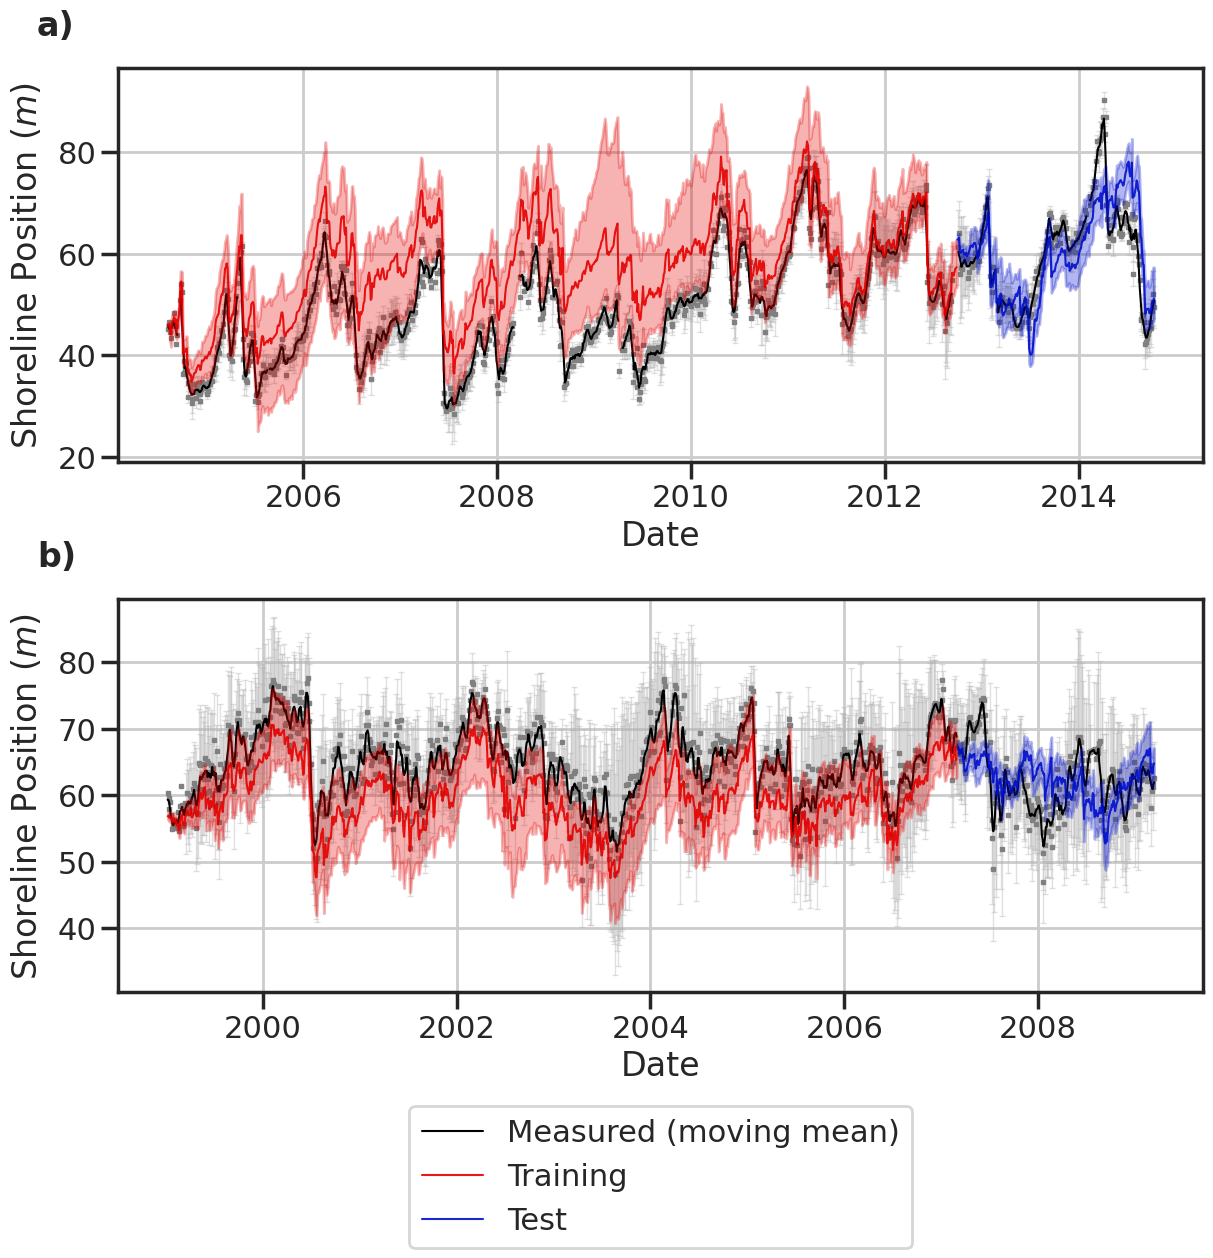

In [19]:
savebool = False
case = 'ar1test'
fold_a = 4
fold_b = 4

sns.set_context("poster")
sns.set_style("ticks",{'axes.grid': True})
# create a figure
fig = plt.figure(figsize=(14,12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)        

# plot one from Narrabeen and one from Tairua      
plot_CV_ensemble(
    narra_ar1test.statsOut,
    fold_a,
    ax=ax1
)
plot_CV_ensemble(
    tairua_ar1test.statsOut,
    fold_b,
    ax=ax2
)
# formatting
ax2.get_legend()._loc = 9
# set bbox to anchor legend
ax2.get_legend().set_bbox_to_anchor((0.5, -0.25))
# add label a) in top left of ax1 and b) in top left of ax2
txt = ax1.text(-0.075, 1.15, 'a)', transform=ax1.transAxes, va='top', fontweight='bold')
ax2.text(-0.075, 1.15, 'b)', transform=ax2.transAxes, va='top', fontweight='bold')
plt.subplots_adjust(hspace=0.35)

if savebool: 
    # save for paper
    savePath =  os.path.join('.','figures','CV', 'case_{}'.format(case),
                                'CVtesting_fold_{}_{}.pdf'.format(fold_a, fold_b))
    os.makedirs(os.path.dirname(savePath), exist_ok=True)
    plt.savefig(savePath, bbox_extra_artists=(ax2.get_legend(),txt), bbox_inches='tight', dpi=600)

plt.show()

# Hysteresis effect

In [20]:
storeDF_narra, obsStoreDF_narra = run_hysteresis_analysis(narra_base,tryNum=5)
storeDF_tairua, obsStoreDF_tairua = run_hysteresis_analysis(tairua_base,tryNum=5)

# combine ready for plotting
storeDF = pd.concat([storeDF_narra,storeDF_tairua],axis=0,ignore_index=True)
obsStoreDF = pd.concat([obsStoreDF_narra,obsStoreDF_tairua],axis=0,ignore_index=True)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:01<00:00,  2.83it/s]


In [21]:
storeDF_narra

-25.0  -23.48  -21.97  -20.45  -18.94  -17.42  -15.91  -14.39  -12.88  \
0     2.293   2.288   2.283   2.277   2.272   2.266   2.261   2.255   2.250   
1     1.268   1.264   1.260   1.256   1.252   1.248   1.245   1.241   1.238   
2     0.500   0.498   0.496   0.495   0.493   0.491   0.490   0.488   0.486   
3    -0.170  -0.172  -0.173  -0.174  -0.175  -0.176  -0.177  -0.178  -0.179   
4     1.531   1.525   1.519   1.513   1.507   1.501   1.496   1.490   1.484   
...     ...     ...     ...     ...     ...     ...     ...     ...     ...   
6195  1.573   1.566   1.559   1.552   1.545   1.538   1.531   1.525   1.518   
6196  2.629   2.623   2.617   2.611   2.605   2.599   2.594   2.588   2.582   
6197  0.303   0.293   0.283   0.273   0.263   0.252   0.242   0.232   0.222   
6198 -1.108  -1.125  -1.142  -1.159  -1.177  -1.194  -1.211  -1.228  -1.245   
6199  1.447   1.439   1.432   1.424   1.417   1.409   1.402   1.395   1.387   

      -11.36  ...  114.39  115.91  117.42  118.94  120.45  121.97  123.48  \
0      2.244  ...   1.776   1.770   1.764   1.759   1.753   1.747   1.742   
1      1.234  ...   0.917   0.913   0.910   0.906   0.903   0.899   0.896   
2      0.485  ...   0.373   0.372   0.370   0.369   0.368   0.366   0.365   
3     -0.180  ...  -0.222  -0.222  -0.221  -0.221  -0.220  -0.220  -0.219   
4      1.479  ...   0.930   0.922   0.915   0.907   0.899   0.891   0.884   
...      ...  ...     ...     ...     ...     ...     ...     ...     ...   
6195   1.512  ...   0.918   0.911   0.904   0.896   0.889   0.881   0.874   
6196   2.577  ...   2.144   2.139   2.135   2.131   2.127   2.123   2.119   
6197   0.212  ...  -0.714  -0.726  -0.738  -0.750  -0.762  -0.774  -0.786   
6198  -1.263  ...  -2.707  -2.725  -2.743  -2.761  -2.779  -2.797  -2.815   
6199   1.380  ...   0.660   0.651   0.642   0.633   0.623   0.614   0.605   

      125.0   site  Hsig  
0     1.736  narra 0.531  
1     0.892  narra 0.639  
2     0.363  narra 0.808  
3    -0.219  narra 0.544  
4     0.877  narra 1.082  
...     ...    ...   ...  
6195  0.867  narra 0.641  
6196  2.115  narra 0.702  
6197 -0.798  narra 0.752  
6198 -2.833  narra 0.898  
6199  0.596  narra 0.643  

[6200 rows x 102 columns]

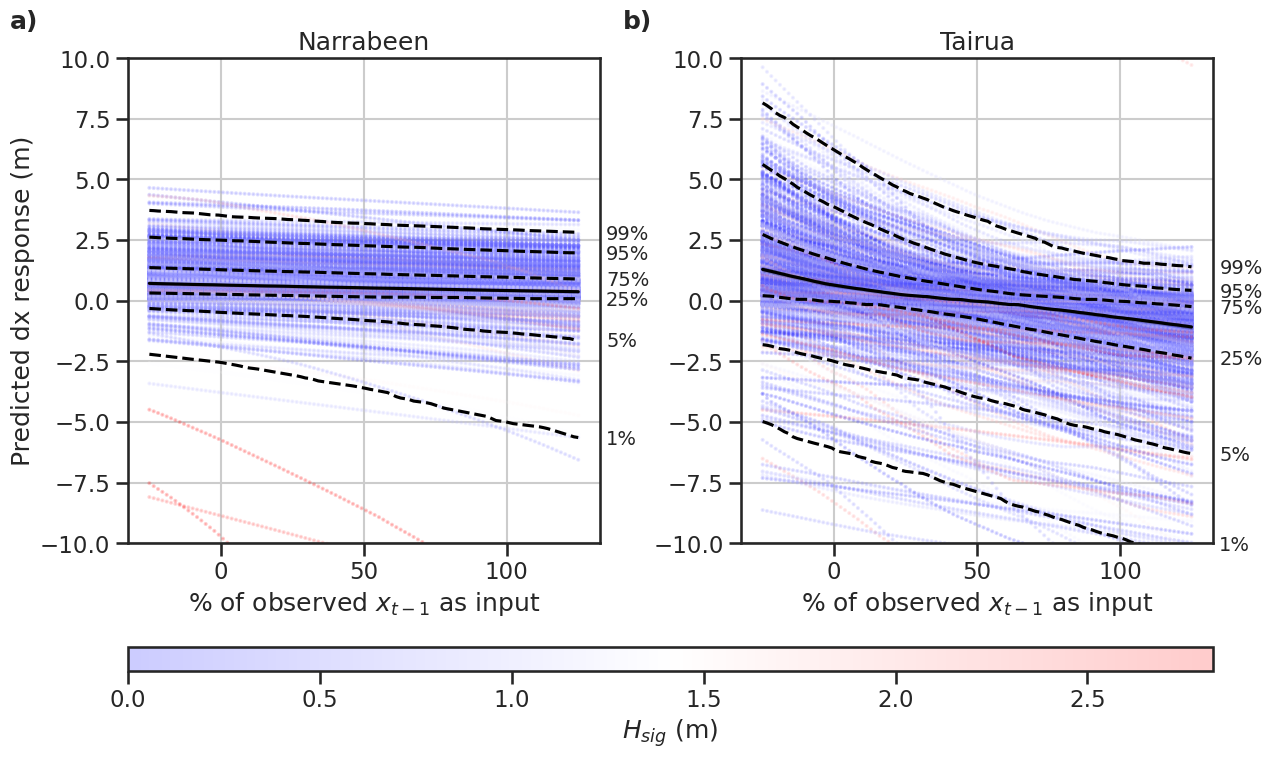

In [22]:
plot_hysteresis(storeDF, case='base', savebool=True)